In [1]:
import os, sys
import importlib

sys.path.insert(0, os.path.abspath("../../hi-ml/src"))
sys.path.insert(0, os.path.abspath("../../hi-ml-azure/src"))
from histopathology.datasets.panda_tiles_dataset import PandaTilesDataset
from health_ml.utils.bag_utils import BagDataset
import histopathology.datamodules.panda_module as panda_module
import histopathology.configs.classification.DeepSMILEPanda as mil_configs
from histopathology.models.transforms import LoadTilesBatchd
from monai.data.dataset import Dataset
import matplotlib.pyplot as plt

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (cloudpickle 2.0.0 (/home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages), Requirement.parse('cloudpickle<2.0.0,>=1.1.0'), {'azureml-dataprep'}).


In [2]:
data_root = "/tmp/datasets"
panda_tiles_root = os.path.join(data_root, "PANDA_tiles")
panda_wsi_root = os.path.join(data_root, "PANDA")
root = "~/workspace/repos/hi-ml/hi-ml-histopathology/src/histopathology/configs/classification"
train_csv = os.path.join(root, "custom_subset/panda/train_tiles_20.csv")
val_csv = os.path.join(root, "custom_subset/panda/val_tiles_5.csv")

## Tiles Exploration

### Data Modules

In [3]:
tiles_ds = PandaTilesDataset(root=panda_tiles_root, dataset_csv=train_csv)
bag_ds = BagDataset(tiles_ds,
                    bag_ids=tiles_ds.slide_ids,
                    shuffle_samples=True)
bag_ds.__getitem__(0).keys()

dict_keys(['tile_id', 'slide_id', 'mask', 'tile_x', 'tile_y', 'occupancy', 'data_provider', 'slide_isup_grade', 'slide_gleason_score', 'image', 'image_path'])

In [4]:
len(bag_ds.__getitem__(0)["image"])

61

In [5]:
transform = LoadTilesBatchd(tiles_ds.IMAGE_COLUMN, allow_missing_keys=True)
dataset = Dataset(bag_ds)
out = transform(dataset.__getitem__(1))
out["image"].shape

torch.Size([65, 3, 224, 224])

### MIL Module

In [6]:
importlib.reload(mil_configs)
mil_test = mil_configs.SubPandaImageNetMIL()
mil_test.setup()
deepmil_module = mil_test.create_model()

/home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [4]:
deepmil_module.encoder.input_dim

(512,)

In [20]:
encoder = mil_test.get_encoder()
print(encoder.input_dim)

(3, 224, 224)


In [21]:
embedding = encoder(out["image"])
embedding.shape

torch.Size([65, 512])

In [22]:
data_module = mil_test.get_data_module()

In [23]:
train, test, val = data_module.get_splits()

In [24]:
bag = data_module._load_dataset(train, stage="train", shuffle=False)

Loading dataset from /tmp/innereye_cache1/SubPandaImageNetMIL-ImageNetEncoder/train_dataset.pt into cpu


## Whole Slide Loading test

In [7]:
importlib.reload(panda_module)
train_csv = os.path.join(root, "custom_subset/panda/train_slides_20.csv")
val_csv = os.path.join(root, "custom_subset/panda/val_slides_5.csv")
wsi_data_module = panda_module.SubPandaSlidesDataModule(root_path=panda_wsi_root,train_csv=train_csv, val_csv=val_csv, batch_size=4, tile_count=56, tile_size=224)

In [8]:
train, test, val = wsi_data_module.get_splits()

In [9]:
train.__getitem__(0)

{<SlideKey.SLIDE_ID: 'slide_id'>: '0005f7aaab2800f6170c399693a96917',
 <SlideKey.IMAGE: 'image'>: '/tmp/datasets/PANDA/train_images/0005f7aaab2800f6170c399693a96917.tiff',
 <SlideKey.IMAGE_PATH: 'image_path'>: '/tmp/datasets/PANDA/train_images/0005f7aaab2800f6170c399693a96917.tiff',
 <SlideKey.MASK: 'mask'>: '/tmp/datasets/PANDA/train_label_masks/0005f7aaab2800f6170c399693a96917_mask.tiff',
 <SlideKey.MASK_PATH: 'mask_path'>: '/tmp/datasets/PANDA/train_label_masks/0005f7aaab2800f6170c399693a96917_mask.tiff',
 <SlideKey.LABEL: 'label'>: 0,
 <SlideKey.METADATA: 'metadata'>: {'data_provider': 'karolinska',
  'isup_grade': 0,
  'gleason_score': '0+0'}}

In [10]:
wsi_dataset = wsi_data_module._load_dataset(stage="train")

In [11]:
len(wsi_dataset.__getitem__(0))

[Plugin: cucim.kit.cuslide] Loading the dynamic library from: /home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages/cucim/clara/cucim.kit.cuslide@22.02.00.so
Initializing plugin: cucim.kit.cuslide (interfaces: [cucim::io::IImageFormat v0.1]) (impl: cucim.kit.cuslide)
[Plugin: cucim.kit.cumed] Loading the dynamic library from: /home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages/cucim/clara/cucim.kit.cumed@22.02.00.so
Initializing plugin: cucim.kit.cumed (interfaces: [cucim::io::IImageFormat v0.1]) (impl: cucim.kit.cumed)


56

In [12]:
data_loader = wsi_data_module._get_dataloader(stage="train", shuffle=True)

In [13]:
X_d = next(iter(data_loader))

In [15]:
X_d["image"].shape

torch.Size([4, 56, 3, 224, 224])

In [16]:
X_d.keys()

dict_keys([<SlideKey.SLIDE_ID: 'slide_id'>, <SlideKey.IMAGE: 'image'>, <SlideKey.IMAGE_PATH: 'image_path'>, <SlideKey.MASK: 'mask'>, <SlideKey.MASK_PATH: 'mask_path'>, <SlideKey.LABEL: 'label'>, <SlideKey.METADATA: 'metadata'>])

In [17]:
X_d["label"]

tensor([5, 0, 0, 0])

In [18]:
X_d["metadata"]

{'data_provider': ['radboud', 'radboud', 'radboud', 'karolinska'],
 'isup_grade': tensor([5, 0, 0, 0]),
 'gleason_score': ['4+5', 'negative', 'negative', '0+0']}

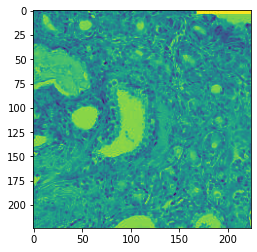

In [43]:
plt.imshow(X_d["image"][0, 1, 2, ...])